<a href="https://colab.research.google.com/github/Pink-Raccoon/MLDM_KaggleProjekt/blob/master/KaggleMiniprojekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goal is to predict category of an incident (from temporal and gegraphical information) Type: Classification

In [15]:
!git clone https://github.com/Pink-Raccoon/MLDM_KaggleProjekt.git

fatal: destination path 'MLDM_KaggleProjekt' already exists and is not an empty directory.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium as fo

#Loading data from file

In [17]:
train_data = pd.read_csv("/content/MLDM_KaggleProjekt/sf-crime/train.csv.zip")
train_data.columns
train_data

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541
...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607


In [18]:
test_data = pd.read_csv("/content/MLDM_KaggleProjekt/sf-crime/test.csv.zip")
test_data.columns

Index(['Id', 'Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y'], dtype='object')

# Data-Processing

In [19]:
#Descript, Resoultion and address are not needed for analysis so they will be dropped
train_data = train_data.drop(columns=['Descript','Resolution', 'Address'])
train_data.dropna(inplace=True)


In [20]:
test_data = test_data.drop(columns=['Address'])
test_data.dropna(inplace=True)

In [21]:
train_data.dtypes

Dates          object
Category       object
DayOfWeek      object
PdDistrict     object
X             float64
Y             float64
dtype: object

In [22]:
#Change datatype of time 
date = pd.to_datetime(train_data["Dates"])
train_data["Year"] = date.dt.year
train_data["Month"] = date.dt.month
train_data["Day"] = date.dt.day
train_data["Hour"] = date.dt.hour
train_data["Minute"] = date.dt.minute
train_data = train_data.drop(columns=['Dates'])
train_data.dropna(inplace=True)

In [23]:
date = pd.to_datetime(test_data['Dates'])
test_data["Year"] = date.dt.year
test_data["Month"] = date.dt.month
test_data["Day"] = date.dt.day
test_data["Hour"] = date.dt.day
test_data["Minute"] = date.dt.minute
test_data = test_data.drop(columns=['Dates'])
test_data.dropna(inplace=True)


#Plotting the Data

Text(0.5, 1.0, 'Hour')

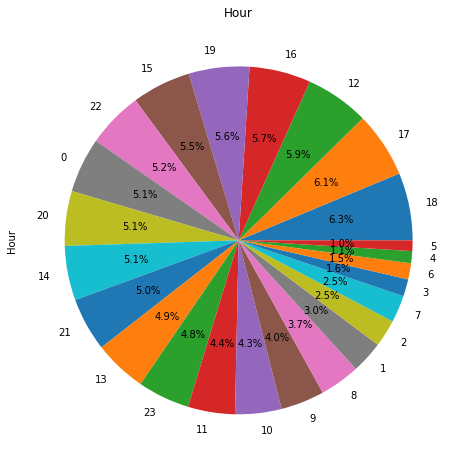

In [24]:
plt.figure(figsize=(15,8))
train_data['Hour'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Hour')

Text(0.5, 1.0, 'DDayOfWeekay')

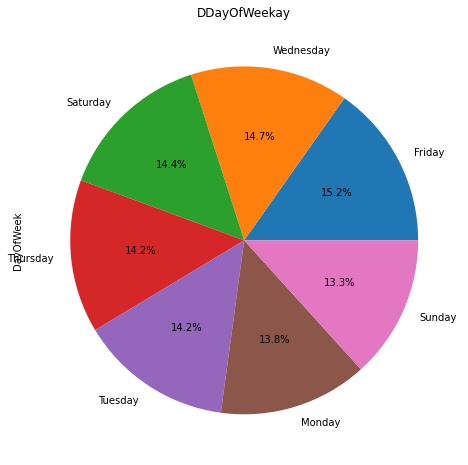

In [25]:
plt.figure(figsize=(15,8))
train_data['DayOfWeek'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('DDayOfWeekay')

Text(0.5, 1.0, 'Year')

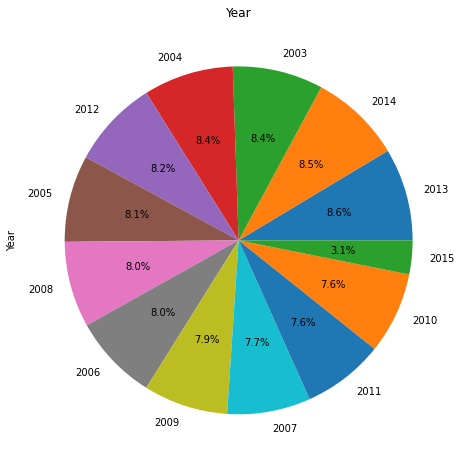

In [26]:
plt.figure(figsize=(15,8))
train_data['Year'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Year')

Text(0.5, 1.0, 'PdDistrict')

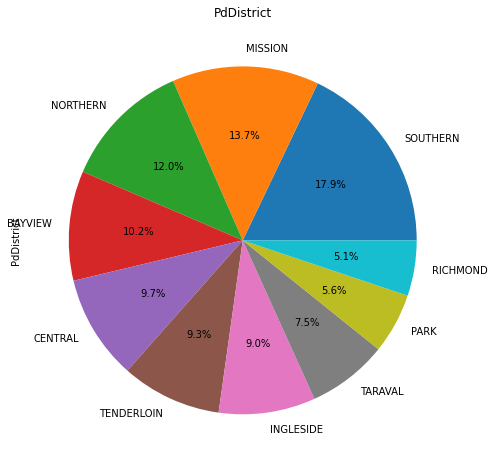

In [27]:
plt.figure(figsize=(15,8))
train_data['PdDistrict'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('PdDistrict')

In [28]:
m = fo.Map(location=[37.773972,-122.446747],zoom_start=13)
fo.Marker(
    location=[37.774599,-122.425892],
    popup="Northern",
    icon=fo.Icon(color="darkgreen"),
).add_to(m)
fo.Marker(
    location=[37.771541,-122.438738],
    popup="Park",
    icon=fo.Icon(color="lightgreen"),
).add_to(m)
fo.Marker(
    location=[37.714056,-122.459033],
    popup="Taraval",
    icon=fo.Icon(color="gray"),
).add_to(m)
fo.Marker(
    location=[37.731948,-122.447364],
    popup="Ingleside",
    icon=fo.Icon(color="pink"),
).add_to(m)
fo.Marker(
    location=[37.780266,-122.403390],
    popup="Southern",
    icon=fo.Icon(color="darkblue"),
).add_to(m)
fo.Marker(
    location=[37.738212,-122.394926],
    popup="Bayview",
    icon=fo.Icon(color="red"),
).add_to(m)
fo.Marker(
    location=[37.78393202772729,-122.412597377187],
    popup="Tenderloin",
    icon=fo.Icon(color="black"),
).add_to(m)
fo.Marker(
    location=[37.7487740050495,-122.42257233421302],
    popup="Mission",
    icon=fo.Icon(color="orange"),
).add_to(m)

fo.Marker(
    location=[37.789434763004	,-122.406958660602],
    popup="Central",
    icon=fo.Icon(color="purple"),
).add_to(m)	
fo.Marker(
    location=[37.7725405391593	,-122.466204667893],
    popup="Richmond",
    icon=fo.Icon(color="lightblue"),
).add_to(m)	







m
